# User Trajectory Analyses

In [1]:
import matplotlib.font_manager as font_manager
import matplotlib.dates as matdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns

sns.set_style("ticks")
fontpath = expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': False
}
mpl.rcParams.update(params)

In [2]:
from helpers import jaccard, populate_bin_with_channel, add_user_to_bin, bins, bins_t_s, bins_y_s, bin_to_df, \
                    add_user_categories_to_bin, mean_confidence_interval, normalize_user_bins, \
                    find_users_constraint, find_users_other_bin, estimate_for_users
from helpers import triple_bin_to_df, intersec_3
from matplotlib.patches import Ellipse, Polygon
from heapq import heappop, heappush 
from matplotlib.lines import Line2D

from sqlitedict import SqliteDict
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np


In [5]:
# Read channels
df_sources = pd.read_csv("../data/sources_final.csv")
authors_dict = SqliteDict("../data/authors_dict.sqlite", tablename="authors")
bin_users = {b:dict() for b in bins_y_s}

In [6]:
min_num_users = 2
for idx, (key, item) in enumerate(authors_dict.items()):
    if idx % 1000000 == 0:
        print(idx)
    relevant_items = [i for i in item if i["category"] in ["Alt-right", "Alt-lite", "Intellectual Dark Web"]]
    if len(relevant_items) < min_num_users:
        continue
    for comment in relevant_items:
        add_user_categories_to_bin(bin_users, key, comment["category"], comment["timestamp"])
normalize_user_bins(bin_users)

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000


## Trajectories Front

In [5]:
constraints = [
               lambda x: x["Alt-right"] == 0,
               lambda x: x["Alt-lite"] == 1,
               lambda x: x["Intellectual Dark Web"] == 1
              ]

constraints_names = ["Alt-lite or I.D.W.", "Alt-lite",  "I.D.W."]

estimates = []

for p in [0.3, 0.6, 0.9]:
    for lamb, cname in zip(constraints, constraints_names):
        for start in list(range(4)):
            non_radical = find_users_constraint(bin_users, bins_y_s[start], lamb)
            tmp = estimate_for_users(bin_users, bins_y_s[start], non_radical, 
                                     lambda xs: mean_confidence_interval([x["Alt-right"] >= p for x in xs]))
            tmp["idx_o"] = start
            tmp["idx"] = bins_y_s[start]
            tmp["start"] = start
            tmp["p"] = p
            tmp["num_users"] = len(non_radical)
            tmp["constraint"] = cname

            print("Num users start:", len(non_radical))
            estimates.append(tmp)
            count = 0
            for bin_key in bins_y_s[start+1:]:
                count += 1
                tracked_users = find_users_other_bin(bin_users, bin_key, non_radical)
                tmp = estimate_for_users(bin_users, bin_key, tracked_users,
                                         lambda xs: mean_confidence_interval([x["Alt-right"] >= p for x in xs]))
                tmp["idx"] =  bin_key
                tmp["idx_o"] = start + count
                tmp["p"] = p
                tmp["start"] = start
                tmp["num_users"] = len(tracked_users)
                tmp["constraint"] = cname

                print("Num users tracked:", len(tracked_users))
                estimates.append(tmp)
df = pd.DataFrame(estimates)


Num users start: 299166
Num users tracked: 127079
Num users tracked: 79713
Num users tracked: 78714
Num users tracked: 85107
Num users start: 728363
Num users tracked: 366410
Num users tracked: 317794
Num users tracked: 312819
Num users start: 1044430
Num users tracked: 628700
Num users tracked: 558576
Num users start: 1413501
Num users tracked: 925583
Num users start: 74699
Num users tracked: 28480
Num users tracked: 19356
Num users tracked: 19603
Num users tracked: 21872
Num users start: 239980
Num users tracked: 110422
Num users tracked: 96713
Num users tracked: 99853
Num users start: 462215
Num users tracked: 249726
Num users tracked: 226611
Num users start: 544977
Num users tracked: 314739
Num users start: 174293
Num users tracked: 71371
Num users tracked: 42677
Num users tracked: 42194
Num users tracked: 46107
Num users start: 322705
Num users tracked: 141963
Num users tracked: 123007
Num users tracked: 122758
Num users start: 293919
Num users tracked: 162755
Num users tracked: 1

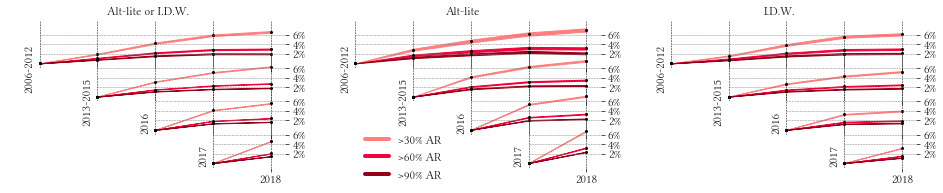

In [6]:
fg = sns.FacetGrid(data=df, col="constraint", hue="p", hue_order=[0.3, 0.6, 0.9], 
                   palette=["#FF7F7F", "#F2003C", "#960018"],
                   row="start", aspect=6, height=0.75)   

fg = fg.map(plt.fill_between, "idx_o",  "lower", "upper")

fg = fg.map(plt.scatter, "idx_o",  "mean", color="black", s=4)

fg.set_titles("")
fg.fig.subplots_adjust(hspace=-0.3, wspace=0.15)

for j in [0,1,2]:
    for i in range(0,4):

        ax = fg.facet_axis(i,j)
        ax.set_facecolor((0, 0, 0, 0))
        sns.despine(ax=ax, bottom=True)
        ax.set_ylim([-0.01, 0.09])
        ax.set_xlim([-0.5, 4.25])
        ax.set_yticks([0.02, 0.04, 0.06])
        ax.set_yticklabels(["2%", "4%", "6%"])
        ax.set_ylabel("{}".format(bins_t_s[i]), horizontalalignment="right")
        ax.yaxis.tick_right()
        ax.yaxis.set_tick_params(labelright=True)
        
        for lp in range(i, 5):
            ax.axvline(lp, linestyle="--", color="black", linewidth=0.5)
        ax.spines["left"].set_position(('data', i))
        
        for lp in [0.02, 0.04, 0.06]:
            ax.plot([i, 12], [lp, lp], linestyle="--", color="grey", linewidth=0.5)
        ax.spines["left"].set_visible(False)


    ax = fg.facet_axis(0,j)

    ax.set_title(constraints_names[j])
    ax = fg.facet_axis(3,j)
#     ax.set_visible(False)
    ax.set_xticks([4])
    ax.set_xticklabels(["2018"])
    ax.set_xlabel("")
    
    if j == 1:

        ax = fg.facet_axis(3,j)
        custom_lines = [Line2D([0], [0], color="#FF7F7F", lw=4),
                Line2D([0], [0], color="#F2003C", lw=4),
                Line2D([0], [0], color="#960018", lw=4)]

        ax.legend(custom_lines, ['>30% AR', '>60% AR', '>90% AR'], 
                  loc="lower left", ncol=1, bbox_to_anchor=(0.1,-0.5), frameon=False)
        
fg.fig.savefig("../imgs/user_traj.pdf", bbox_inches='tight')
fg.fig.savefig("../imgs/user_traj.png", bbox_inches='tight')

## Trajectories Backwards

In [7]:
constraints = [ lambda x: 0.50 > x["Alt-right"] >= 0.25,
                lambda x: 0.75 > x["Alt-right"] >= 0.50,
                lambda x: 1.00 > x["Alt-right"] >= 0.75 #,
              ]

constraints_names = ["50% > Alt-right ≥ 25%", " 75% > Alt-right ≥ 50%",  "100% > Alt-right ≥ $75%"]


estimates = []
for p in [0.0, 0.125, 0.25]: 

    for lamb, cname in zip(constraints, constraints_names):
        for start in list(range(4, 0,-1)):
            print("start", start, bins_t_s[start])
            radical = find_users_constraint(bin_users, bins_y_s[start], lamb)
            tmp = estimate_for_users(bin_users, bins_y_s[start], radical, 
                                     lambda xs: mean_confidence_interval([x["Alt-right"] <= p for x in xs]))
            tmp["idx_o"] = abs(4 - start)
            tmp["idx"] = bins_y_s[start]
    #         print(tmp["idx_o"], tmp["idx"], tmp["mean"])
            tmp["p"] = p

            tmp["start"] = abs(4 - start)
            tmp["num_users"] = len(radical)
            tmp["constraint"] = cname

            print("Num users start:", len(non_radical))
            estimates.append(tmp)
            count = 0
            print("---->", list(reversed(bins_t_s[0:start])))
            for bin_key in reversed(bins_y_s[0:start]):
                print(bin_key)
                count += 1
                tracked_users = find_users_other_bin(bin_users, bin_key, radical)
                tmp = estimate_for_users(bin_users, bin_key, tracked_users,
                                         lambda xs: mean_confidence_interval([x["Alt-right"] <= p for x in xs]))
                tmp["idx"] =  bin_key
                tmp["idx_o"] = abs(4-start) + count
                print(tmp["idx_o"], tmp["idx"], tmp["mean"])
                tmp["p"] = p

                tmp["start"] = abs(4 - start)
                tmp["num_users"] = len(tracked_users)
                tmp["constraint"] = cname

                print("Num users tracked:", len(tracked_users))
                estimates.append(tmp)
df =  pd.DataFrame(estimates)

start 4 2018
Num users start: 490281
----> ['2017', '2016', '2013-2015', '2006-2012']
(1493553600000, 1525089600000)
1 (1493553600000, 1525089600000) 0.5634763203570543
Num users tracked: 40330
(1462017600000, 1493553600000)
2 (1462017600000, 1493553600000) 0.6965979038429546
Num users tracked: 24044
(1367323200000, 1462017600000)
3 (1367323200000, 1462017600000) 0.8163764130766881
Num users tracked: 13092
(1146398400000, 1367323200000)
4 (1146398400000, 1367323200000) 0.9468739876903142
Num users tracked: 3087
start 3 2017
Num users start: 490281
----> ['2016', '2013-2015', '2006-2012']
(1462017600000, 1493553600000)
2 (1462017600000, 1493553600000) 0.6167553806989123
Num users tracked: 21605
(1367323200000, 1462017600000)
3 (1367323200000, 1462017600000) 0.7730853792598021
Num users tracked: 10916
(1146398400000, 1367323200000)
4 (1146398400000, 1367323200000) 0.9348612786489746
Num users tracked: 2487
start 2 2016
Num users start: 490281
----> ['2013-2015', '2006-2012']
(13673232000

1 (1493553600000, 1525089600000) 0.7726258368460204
Num users tracked: 40330
(1462017600000, 1493553600000)
2 (1462017600000, 1493553600000) 0.8733571785060722
Num users tracked: 24044
(1367323200000, 1462017600000)
3 (1367323200000, 1462017600000) 0.9078062939199512
Num users tracked: 13092
(1146398400000, 1367323200000)
4 (1146398400000, 1367323200000) 0.970197602850664
Num users tracked: 3087
start 3 2017
Num users start: 490281
----> ['2016', '2013-2015', '2006-2012']
(1462017600000, 1493553600000)
2 (1462017600000, 1493553600000) 0.8216153668132377
Num users tracked: 21605
(1367323200000, 1462017600000)
3 (1367323200000, 1462017600000) 0.8872297544888238
Num users tracked: 10916
(1146398400000, 1367323200000)
4 (1146398400000, 1367323200000) 0.9666264575794129
Num users tracked: 2487
start 2 2016
Num users start: 490281
----> ['2013-2015', '2006-2012']
(1367323200000, 1462017600000)
3 (1367323200000, 1462017600000) 0.8383348231388073
Num users tracked: 7831
(1146398400000, 1367323

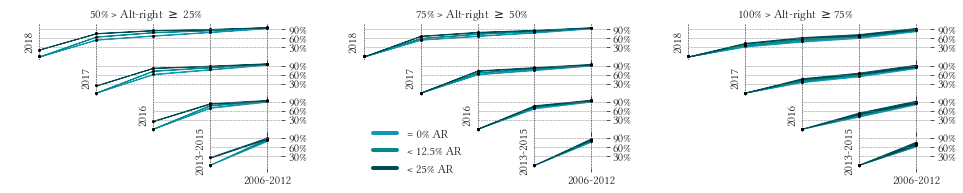

In [8]:

fg = sns.FacetGrid(data=df, col="constraint", row="start", aspect=6, height=0.75,
                  hue="p", hue_order=[0.0, 0.125, 0.25], 
                   palette=["#0D98BA", "#008B8B", "#004C54"])    

fg = fg.map(plt.fill_between, "idx_o",  "lower", "upper")

fg = fg.map(plt.scatter, "idx_o",  "mean", color="black", s=4)

fg.set_titles("")
fg.fig.subplots_adjust(hspace=-0.0, wspace=0.2)

for j in [0,1,2]:
    for i in range(0,4):
        ax = fg.facet_axis(i,j)
        ax.set_facecolor((0, 0, 0, 0))
        sns.despine(ax=ax, bottom=True)
        ax.set_ylim([-0.1, 1.1])
        
        ax.set_xlim([-0.125, 12.125])
        ax.set_xlim([-0.5, 4.25])
        ax.set_yticks([0.3, 0.6, 0.9])
        ax.set_yticklabels(["30%", "60%", "90%"])
        ax.set_ylabel("{}".format(list(reversed(bins_t_s))[i], horizontalalignment="right"))
        ax.yaxis.tick_right()
        ax.yaxis.set_tick_params(labelright=True)
        
        for lp in range(i, 5):
            ax.axvline(lp, linestyle="--", color="black", linewidth=0.5)
        ax.spines["left"].set_position(('data', i))
        
        for lp in [0.3, 0.6, 0.9]:
            ax.plot([i, 12], [lp, lp], linestyle="--", color="grey", linewidth=0.5)
        ax.spines["left"].set_visible(False)



    ax = fg.facet_axis(0,j)

    ax.set_title(constraints_names[j])
    ax = fg.facet_axis(3,j)
    ax.set_xticks([4])
    ax.set_xticklabels(["2006-2012"])
    ax.set_xlabel("")
    
    if j == 1:

        ax = fg.facet_axis(3,j)
        custom_lines = [Line2D([0], [0], color="#0D98BA", lw=4),
                Line2D([0], [0], color="#008B8B", lw=4),
                Line2D([0], [0], color="#004C54", lw=4)]
        ax.legend(custom_lines, ['= 0% AR', '< 12.5% AR', '< 25% AR'], 
                  loc="lower left", ncol=1, bbox_to_anchor=(0.1,-0.5), frameon=False)
        
fg.fig.savefig("../imgs/user_traj_back.pdf", bbox_inches='tight')
fg.fig.savefig("../imgs/user_traj_back.png", bbox_inches='tight')